---
title: "Quality Control: initial steps"
author:
    - name: Conor O'Hare
    - name: Samuele Soraggi
      orcid: 0000-0002-1159-5535
      email: samuele@birc.au.dk
    - name: Alba Refoyo Martinez
      orcid: 0000-0002-3674-4007
      email: alba.martinez@sund.ku.dk     
---

::: {.callout-note title="Important notes for this notebook" icon=false}

After gathering your data and genotyping, there are many checks to do to determine the quality of the data. It is crucial to **perform quality control before** carrying out any GWAS, otherwise, there is the risk that some of the associations are spurious.

## Learning outcomes

- **Distinguish** the various QC steps
- **Discuss and choose** thresholds on plink
- **Implement** basic QC in `plink` and statistical plots in `R`
- **Hypothesize** the effects of various `plink` commands and **verify** your hypothesis using the analysis in `R`


## How to make this notebook work

* In this notebook, we will use both `R` and `bash command line` programming languages. Remember to **change the kernel** whenever you transition from one language to the other (`Kernel --> Change Kernel`) indicated by the languages' images. We will first run `Bash` commands.  
  
<img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash kernel

:::

The next critical step in any GWAS involves **scrutinizing the data for potential issues**. It's crucial to ensure that the results are not merely artifacts of poor data quality discovered after the analysis. 

After gathering your data and genotyping, there are many checks one can do to determine the quality of the data. PLINK provides several summary statistics for quality control (e.g. missing genotype rate, minor allele frequency, and Hardy-Weinberg equilibrium failures) which will serve as thresholds for subsequent analyses. 

For this tutorial, we will look at the following topics: 

1) Individual Missingness  
2) Sex discrepancy  
3) Minor Allele Frequency (MAF)  
4) Hardy-Weinberg Equilibrium (HWE)  
5) Heterozygosity Rate


# Individual and SNP Missingness

## Missingness per SNP

Overall, the SNP genotyping platform is very reliable and delivers stable results when it comes to determining genotypes. Of course, it is not flawless. One of the most frequent problems is that some of the SNPs are just not well-genotyped in the entire population. These should be removed to improve the overall data quality.

Certainly, we can't remove every SNP with any missing values, as that would result in losing a significant portion of our data. Instead, we adopt defined **thresholds**. However, determining these thresholds isn't governed by strict rules. You have the flexibility to set them within "reasonable" limits. To find out what constitutes "reasonable," consulting relevant literature for your species of interest is advisable. For humans, a common starting point is a threshold of 0.2, meaning we exclude SNPs where 20% or more of the genotypes are missing in our population.

## Missingness per individual

The reliability of SNP chips is also high when it comes to individual genotypes. In some cases, however, some of the individuals contain a large number of missing SNPs. The reason could be low DNA sample quality, the wrong chip type used (e.g. cattle chip for deer samples), or other technical issues. Regardless of the reason, you should remove the worst offenders from your data set, to not compromise the overall quality of your results.

:::{.callout-important title="Stop - Read - Solve"}

Have a look at the following toy example:

|   /   | SNP1 | SNP2 | SNP3 | SNP4 | SNP5 |
|------|------|------|------|------|------|
| IND1 | 22   | 00   | 11   | 12   | 22   |
| IND2 | 22   | 00   | 11   | 12   | 22   |
| IND3 | 11   | 12   | 11   | 22   | 21   |
| IND4 | 00   | 00   | 11   | 11   | 00   |
| IND5 | 22   | 00   | 11   | 22   | 22   |

Here, we have a data set of five individuals, each of them genotyped for five SNPs. The genotypes themselves are in numerical coding, 11 and 22 being the two homozygous, 12 the heterozygous, and 00 coded as missing. We want to apply two filters: one for the variants, and one for the individuals.

- First remove variants with >= 40% missingness
- Then remove individuals with >= 40% missingness

Which variants and individuals are we removing?


In practice, you want to **remove the SNPs based on missingness before the individuals**. This is simply because we generally have a lot more SNPs than individuals, and would thus lose less information by removing SNPs than individuals. This will remove "bad" SNPs first, leaving a lower rate of missingness for all the individuals.

:::{.callout-tip title="Solution" collapse="true"}

**Variant-level threshold**: In this example, we would only remove SNP2 since it exceeds this threshold, with 80% missingness (4 out of 5 missing values).

**Individual-level threshold**: IND4 is removed from the data set, as there is missing genotype information for 2/4 = 50% SNPs (after filtering out SNP2). 

:::


## First run of the PLINK tool

Using PLINK, we can address missing data using two functions; one operates at the variant level and the other at the individual level:

* `--geno`: This will remove SNPs with a specified proportion of missingness (e.g. `--geno 0.01` will remove SNPs with 1% missingness).
* `--mind`: This will remove individuals with a specified proportion of missingness (e.g. `--mind 0.01` will remove individuals with 1% missingness).

A common threshold for --mind and --geno ranges from 1% to 5% to ensure quality and robustness. Higher thresholds may be acceptable if the study has a large sample size and missingness is not widespread. Those filters must run one at a time in PLINK.

We now implement our first QC method in PLINK:

<img src="Images/bash.png" alt="Bash" width="40"> We link the data folder to easily access it by using the `ln -sf` command and create a folder for the output files (`Results/GWAS3`) 

In [1]:
ln -sf ../Data
mkdir -p Results/GWAS3

PLINK program uses options implemented using the `--` symbol to perform different functions or access files. We will use the option `--bfile` for data (filename without extension), `--missing` for missing data summary, and `--out` for output prefixes. This helps us analyze data missingness.

In [2]:
plink --bfile Data/HapMap_3_r3_1 --missing --out Results/GWAS3/data

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/data.log.
Options in effect:
  --bfile Data/HapMap_3_r3_1
  --missing
  --out Results/GWAS3/data

385567 MB RAM detected; reserving 192783 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... done.
commands treat these as missing.
Total genotyping rate is 0.997378.
--missing: Sample missing data report written to Results/GWAS3/data.imiss, and
variant-based missing data report written to Results/GWAS3/data.lmiss.


:::{.callout-important title="Stop - Read - Solve"}

PLINK prints a lot of information. Make sure you read it. 

1. Which file formats are read by PLINK to understand the data?
2. What is the percentage of valid genotype data?
3. What is the count of females and males?
4. What files are generated as output from the command?

:::

:::{.callout-tip title="Solution"}
1. PLINK reads two files in the format *.fam* and *.bim* for this task. As explained in the notebook GWAS2, these files contain data for individuals and variants, respectively.
2. Immediately we can see that the total genotyping rate for our sample is 0.997378.
3. It counts 80 males and 85 females
4. It prints the name of the two output files from this command: `data.imiss` and `data.lmiss`, in the directory `Results/GWAS3/`. These files show the proportion of **missing SNPs per individual** and the proportion of **missing individuals per SNP**, respectively.

:::

We can see a preview of the files to understand their structure. The first individuals of the `imiss` file do not seem to miss phenotypes (column `MISS_PHENO`) and have some proportion of missing genotypes (column `F_MISS`). Similarly, some variants in the `lmiss` file have missing data.

In [4]:
head -5 Results/GWAS3/data.imiss

    FID       IID MISS_PHENO   N_MISS   N_GENO   F_MISS
   1328   NA06989          N     4203  1457897 0.002883
   1377   NA11891          N    20787  1457897  0.01426
   1349   NA11843          N     1564  1457897 0.001073
   1330   NA12341          N     6218  1457897 0.004265


In [5]:
head -5 Results/GWAS3/data.lmiss

 CHR         SNP   N_MISS   N_GENO   F_MISS
   1   rs2185539        0      165        0
   1  rs11510103        4      165  0.02424
   1  rs11240767        0      165        0
   1   rs3131972        0      165        0


<img src="Images/R.png" alt="R" width="40"> We can use the output files of PLINK to visualize the distribution of the missingness in individuals and SNPs using histograms in `R`. The package used here for visualization is `ggplot2`. Each plot has various elements which are put together with the `+` symbol. Look below at the `R` code and the output.

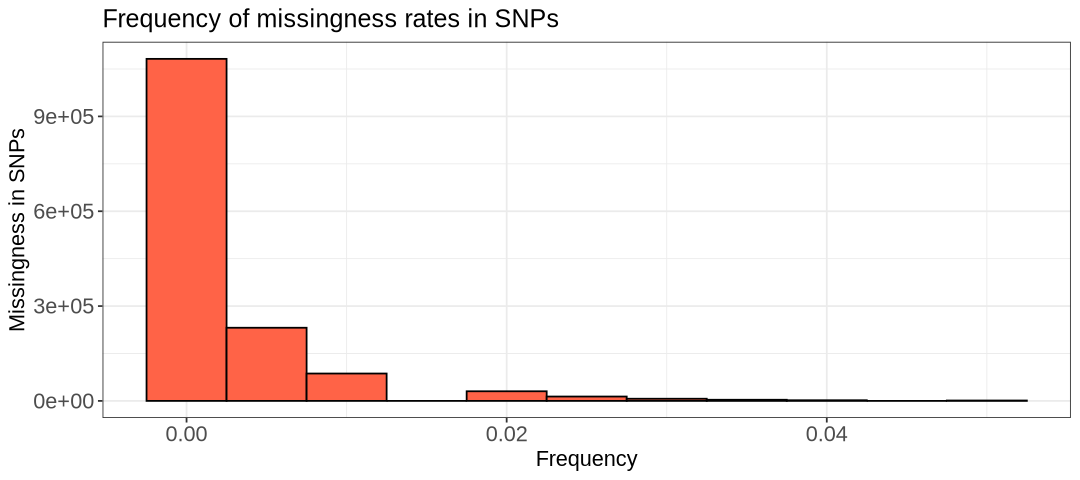

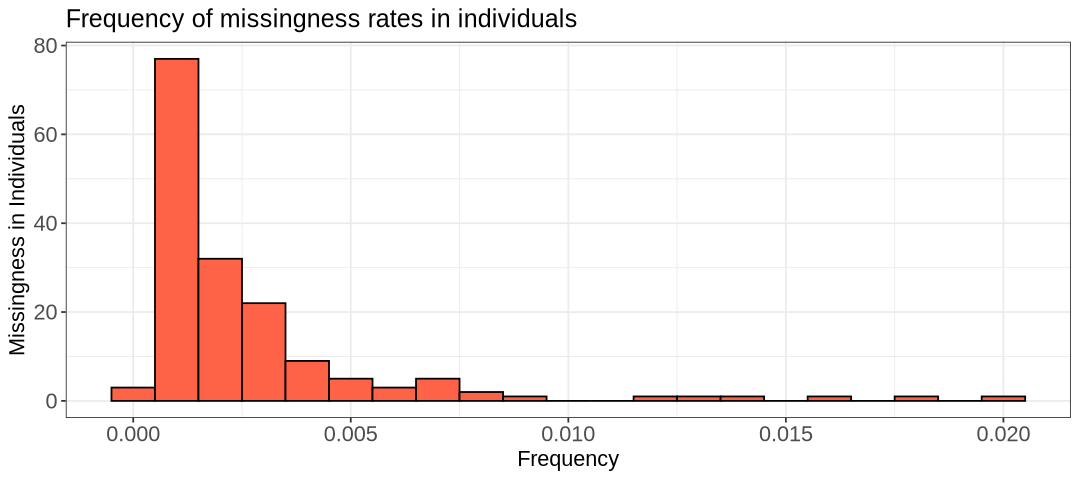

In [3]:
suppressWarnings(library(ggplot2))
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
indmiss <- read.table(file="Results/GWAS3/data.imiss", header=TRUE)
snpmiss <- read.table(file="Results/GWAS3/data.lmiss", header=TRUE)

#lmiss histogram
hist.lmiss <- ggplot(snpmiss, aes(x=snpmiss[,5])) +
    geom_histogram(binwidth = 0.005, col = "black", fill="tomato") + 
    labs(title = "Frequency of missingness rates in SNPs") + 
    xlab("Frequency") + 
    ylab("Missingness in SNPs") + 
    theme_bw() +
    theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))


#imiss histogram
hist.imiss <- ggplot(indmiss, aes(x=indmiss[,6])) +
    geom_histogram(binwidth = 0.001, col = "black", fill="tomato") + 
    labs(title = "Frequency of missingness rates in individuals") + 
    xlab("Frequency") + 
    ylab("Missingness in Individuals") + 
    theme_bw() +
    theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))

#show histograms
show(hist.lmiss)
show(hist.imiss)

# Save plots silently
suppressMessages({
ggsave(plot=hist.lmiss, filename="Results/GWAS3/histlmiss.png");
ggsave(plot=hist.imiss, filename="Results/GWAS3/histimiss.png");
})

Histograms are saved in your results directory as `histimiss.png` and `histlmiss.png`. 

:::{.callout-important title="Stop - Read - Solve"}
- What is the highest percentage of missingness for a SNP?
- Are there individuals with no missing data?

:::


:::{.callout-tip title="Solution"}
Here are a few observations we can make. Firstly, it's clear that very few individuals have no missing data at all. One interpretation could be that one or a few SNPs are poorly genotyped across all samples. Fortunately, this isn't the case here, otherwise the first plot would show many more SNPs with high missing frequency. As shown in the SNP-based histogram, the highest percentage of missing data for a SNP is around 0.05 (5%). Overall, the histogram provides insight into how applying a missingness filter will affect the size of your remaining data.
:::

<img src="Images/bash.png" alt="Bash" width="40">  Next, we will use PLINK to filter the data using missingness thresholds to ensure data quality.

We choose a 2% missingness threshold for both individuals and SNP, as only a few outliers exceed this rate (this threshold does not need to be the same for SNPs and individuals). Below, we provide the command to remove samples (`--mind`) and SNPs (`--geno`) above this threshold. The `--out` option defines the output prefix, and `--make-bed` denotes the output format. PLINK provides detailed output during execution, so check the printed text to monitor progress.

In [1]:
# Delete samples with missing call freq > 2% and SNPs with missingness > 2%
plink --bfile Data/HapMap_3_r3_1 --mind .02 --geno .02 --make-bed --out Results/GWAS3/HapMap_3_r3_2

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_2.log.
Options in effect:
  --bfile Data/HapMap_3_r3_1
  --geno .02
  --make-bed
  --mind .02
  --out Results/GWAS3/HapMap_3_r3_2

385567 MB RAM detected; reserving 192783 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
1 person removed due to missing genotype data (--mind).
ID written to Results/GWAS3/HapMap_3_r3_2.irem .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
); many commands treat these

:::{.callout-important title="Stop - Read - Solve"}

What happened during filtering?

- How many individuals and variants were removed?
- Can you preview the output files? 

:::

:::{.callout-tip title="Solution" collapse="true"}

:::

Only 1 individual has been removed, while 26686 variants where above the filtering threshold.
We can see a preview of the output files: those are again a set of `fam`, `bim` and `bed` file including only the data passing the filters. For the first two formats we can use `head`, while for the `bed` file we need also `xxd` because of the binary nature of the file.

In [2]:
head -5 Results/GWAS3/HapMap_3_r3_2.fam

1328 NA06989 0 0 2 2
1377 NA11891 0 0 1 2
1349 NA11843 0 0 1 1
1330 NA12341 0 0 2 2
1344 NA10850 0 NA12058 2 -9


In [3]:
head -5 Results/GWAS3/HapMap_3_r3_2.bim

1	rs2185539	0	556738	T	C
1	rs11240767	0	718814	T	C
1	rs3131972	0	742584	A	G
1	rs3131969	0	744045	A	G
1	rs1048488	0	750775	C	T


In [4]:
xxd -b Results/GWAS3/HapMap_3_r3_2.bed | head -5

00000000: 01101100 00011011 00000001 11111111 11111111 11111111  l.....
00000006: 11111111 11111111 11111111 11111111 11111111 11111111  ......
0000000c: 11111111 11111111 11111111 11111111 11111111 11111111  ......
00000012: 11111111 11111111 11111111 11111111 11111111 11111111  ......
00000018: 11111111 11111111 11111111 11111111 11111111 11111111  ......


***
# Sex Discrepancy

One useful check is verifying if the indicated genders are correct. Using PLINK, you can calculate the inbreeding coefficient on the X chromosome under the assumption that it is an autosomal chromosome. This approach is insightful because PLINK treats haploid chromosomes (like the X chromosome in males) as homozygotes due to technical reasons. Consequently, assuming the X chromosome is autosomal makes males appear highly inbred on the X, whereas females do not (since they have two X chromosomes). As a result, the inbreeding coefficient estimates will be close to 1 for males and 0 for females.

## PLINK Commands

This gender check can be performed in PLINK using the `--check-sex` option. The results are outputted in the file with extension `.sexcheck` (in the `Results/GWAS4` folder) in which the gender is in column `PEDSEX` (1 means male and 2 means female) and the inbreeding coefficient is in column `F`). 

Generally, males should have an X chromosome homozygosity estimate >0.8 and females should have a value <0.2. So we could simply remove any individuals where the homozygosity estimate (F) does not match their specified sex. Subjects who do not fulfil these requirements are flagged "PROBLEM" by PLINK in the output file.

Note the option `--silent` to avoid long texts printed out on the screen.

In [5]:
plink --bfile Results/GWAS3/HapMap_3_r3_2 --check-sex --out Results/GWAS3/HapMap_3_r3_2 --silent

); many commands treat these as missing.


<img src="Images/R.png" alt="R" width="40">  We can visualise the results of the sex check by plotting three histograms for the F values in males, females, and all samples:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


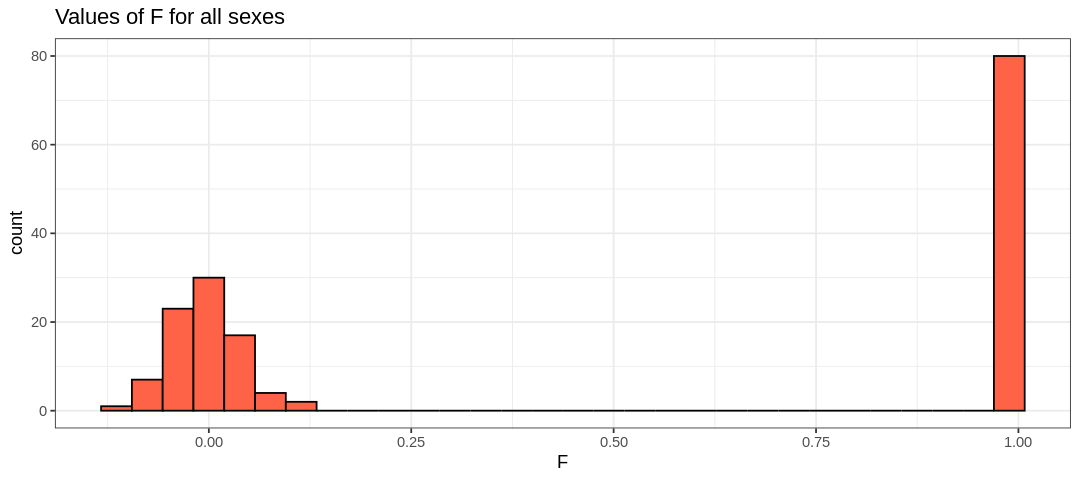

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


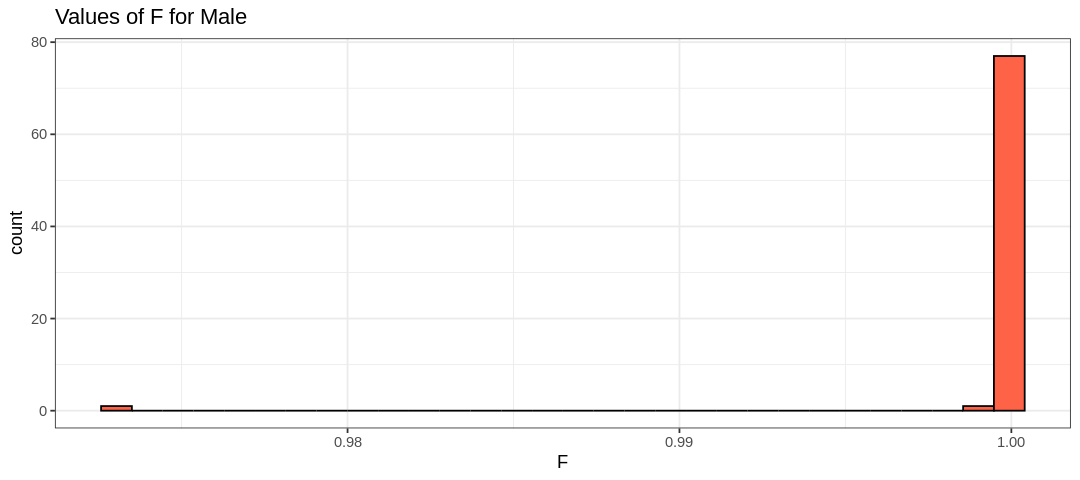

Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Saving 6.67 x 6.67 in image
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


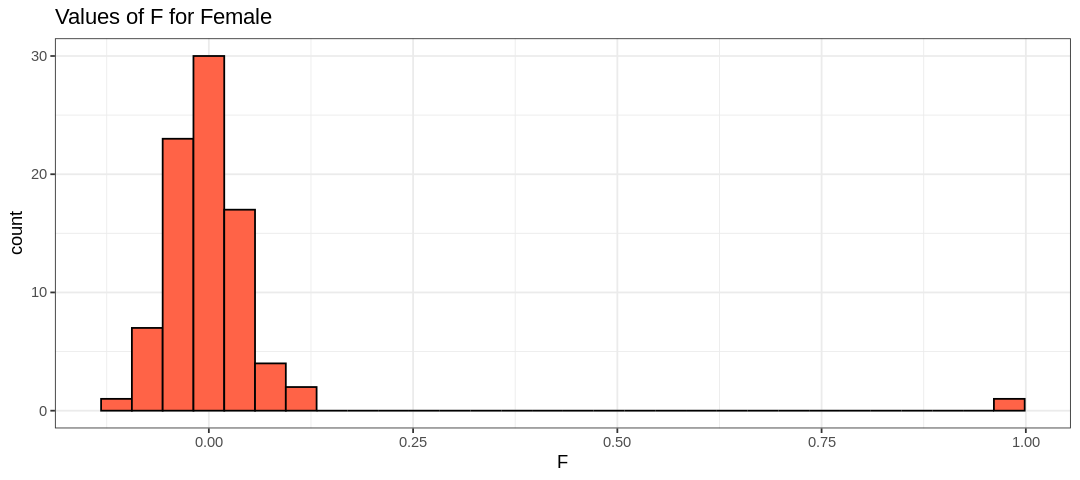

In [1]:
#| label: fig-F
#| fig-cap: "inbreeding coefficients for all genders and for males/females separately."

suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R
gender <- read.table("Results/GWAS3/HapMap_3_r3_2.sexcheck", header=T,as.is=T)
male <- subset(gender, gender$PEDSEX==1)
female <- subset(gender, gender$PEDSEX==2)

# plink.imiss histogram
hist.gender <- ggplot(gender, aes(x=gender[,6])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "Values of F for all sexes") + 
  xlab("F") + 
  theme_bw()

# plink.imiss histogram
hist.male <- ggplot(male, aes(x=male[,6])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "Values of F for Male") + 
  xlab("F") + 
  theme_bw()


# plink.imiss histogram
hist.female <- ggplot(female, aes(x=female[,6])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "Values of F for Female") + 
  xlab("F") + 
  theme_bw()

show(hist.gender)
show(hist.male)
show(hist.female)

# Save plots 
ggsave(plot=hist.gender, filename="Results/GWAS3/histgender.png")
ggsave(plot=hist.male, filename="Results/GWAS3/histmale.png")
ggsave(plot=hist.female, filename="Results/GWAS3/histfemale.png")

The inbreeding coefficient plot of @fig-F indicates that there is one woman with a sex discrepancy (F value of 0.99). When using other datasets often a few discrepancies might be found. 

We have two options when dealing with sex discrepancy. One is to simply remove any individual with sex discrepancy. In our case, this would involve removing the female with the F value of 0.99. 

<img src="Images/bash.png" alt="bash" width="40">  Removal can be done with the command below. Use `grep` to find lines in the sexcheck file that contain `PROBLEM`. Then, pipe (send) the output to the command `awk` (using the so-called pipe symbol `|`). `awk` will extract the first two columns from each line identified by the `grep` command and redirect them to the file `sex_discrepancy.txt` using the symbol `>` (redirecting the output away from the screen/terminal).

In [1]:
grep "PROBLEM" Results/GWAS3/HapMap_3_r3_2.sexcheck | awk '{print$1,$2}'> Results/GWAS3/sex_discrepancy.txt

Show the content of the file using `cat`:

In [2]:
cat Results/GWAS3/sex_discrepancy.txt

1349 NA10854


For long files, you can simply count the number of lines in the file with `wc` (word count command)

In [3]:
wc -l Results/GWAS3/sex_discrepancy.txt

1 Results/GWAS3/sex_discrepancy.txt


The file can be provided to PLINK for removal of sex-discrepant individuals using the option `--remove`:

In [5]:
plink --bfile Results/GWAS3/HapMap_3_r3_2 --remove Results/GWAS3/sex_discrepancy.txt --make-bed --out Results/GWAS3/HapMap_3_r3_3 --silent

); many commands treat these as missing.


:::{.callout-note}

Another approach supported by PLINK is to impute the sex codes based on the SNP data, which is done with the command `--impute-sex` as shown below. 

```{.bash}
plink --bfile Results/GWAS3/HapMap_3_r3_2 --impute-sex --make-bed --out Results/GWAS3/HapMap_3_r3_3
```

PLINK finds out automatically how to impute the wrong genders, so you need just to type the extra option into it. However, we will not be executing this command. Instead, we will keep only the dataset where we filtered out the wrong gender.

:::

# Minor Allele Frequency (MAF)

Excluding SNPs based on minor allele frequency (MAF) is somewhat controversial. In a sense, it has little to do with quality control – there is no reason to think there are any errors in the data. The main justification is statistical:

- If MAF is low, and the SNP is rare, then the power is low (i.e. don’t spend multiple testing corrections on tests that are unlikely to find anything anyway).
- Some statistical methods perform badly with low MAF (e.g. the chi-squared-test).

An appropriate cutoff definitely depends on sample size – the larger the sample, the greater your ability to include rare SNPs. Typically, researchers utilize thresholds  of 0.1 or 0.05 (@kanaka_concepts_2023).

## Command

Filtering data based on the minor allele frequencies is done in a similar way to previous commands. If you want to get rid only of the fixed SNPs, you specify a MAF threshold of 0, which can be done by the command `--maf 0`

:::{.callout-warning}

One should **limit MAF analysis to only autosomal chromosomes**, meaning you need to generate a subset of the data containing only autosomal chromosomes as done below.

:::

We extract the SNP identifiers from chromosomes 1 to 22 with `awk`, and redirect the output to the file `snp_1_22.txt`. Then, PLINK can extract those SNPs using the option `--extract`.

In [6]:
awk '{ if ($1 >= 1 && $1 <= 22) print $2 }' Results/GWAS3/HapMap_3_r3_3.bim > Results/GWAS3/snp_1_22.txt
plink --bfile Results/GWAS3/HapMap_3_r3_3 --extract Results/GWAS3/snp_1_22.txt --make-bed --out Results/GWAS3/HapMap_3_r3_4 --silent

:::{.callout-important title="Stop - Read - Solve"}

How can you verify if only the autosomal regions are present in the output? Try to visualize the chromosomes from one of the output files.

:::

In [1]:
#write your code

:::{.callout-tip title="Solution"}

SNPs are saved in the output `bim` file. The first column of this file contains the chromosome names. So we simply need to print those, extract the first column, and check the unique names (as extra, we count how many times each chromosome occur):

In [15]:
cut -f 1 Results/GWAS3/HapMap_3_r3_4.bim | uniq -c

 117486 1
 117527 2
  97357 3
  86412 4
  88839 5
  92059 6
  75941 7
  75794 8
  64194 9
  74392 10
  71825 11
  69411 12
  52348 13
  45631 14
  42297 15
  45099 16
  38736 17
  41147 18
  26439 19
  36631 20
  19427 21
  20314 22


:::

---

Now that we have a set of files with autosomal chromosomes only, we should have a look at the summary statistics for the minor allele frequency, and plot the values on a histogram. We can do this using the `--freq` option in PLINK:

In [7]:
# Generate a plot of the MAF distribution.
plink --bfile Results/GWAS3/HapMap_3_r3_4 --freq --out Results/GWAS3/MAF_check --silent

<img src="Images/R.png" alt="R" width="40"> Let's plot the MAF histogram using `R`. The second plot, is a zoom-in version with MAF up to 0.1 to observe the low MAF values. 

In [ ]:
#| label: fig-MAF
#| fig-cap: "MAF plot for the autosomal SNPs only. Note the zoomed interval (0, 0.1)"

suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
maf_freq <- read.table("Results/GWAS3/MAF_check.frq", header =TRUE, as.is=T)

# maf_freq histogram
hist.maf <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "MAF distribution") + 
  xlab("MAF") + 
  ylab("Frequency") +
  theme_bw()

# zoom-in into X-axis
hist.maf.zoom <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato", bins = 10) + 
  labs(title = "Zoom into MAF distribution up to value 0.1") + 
  xlab("MAF") + 
  ylab("Frequency") +
  xlim(-.01, 0.1) +
  theme_bw()


show(hist.maf)
show(hist.maf.zoom)

# Save plots 
suppressMessages(ggsave(plot=hist.maf, filename="Results/GWAS3/histmaf.png"))

<img src="Images/bash.png" alt="bash" width="40"> As stated above, your MAF threshold depends on sample size, though a conventional MAF threshold for a regular GWAS is between 0.1 and 0.05. Here, to ensure the inclusion of only SNPs we will apply a MAF threshold of 0.05 (that is, remove SNPs where the MAF is 5% or less). The threshold is given with the option `--maf`:

In [1]:
# Remove SNPs with a low MAF frequency.
plink --bfile Results/GWAS3/HapMap_3_r3_4 --maf 0.05 --make-bed --out Results/GWAS3/HapMap_3_r3_5 --silent

:::{.callout-important title="Stop - Read - Solve"}

Determine the number of SNPs remaining after applying quality control measures.
Hint: Check the `.bim` file from the output located in `Results/GWAS3/HapMap_3_r3_5`.

:::

In [ ]:
#Write your code here

:::{.callout-tip title="Solution"}

Simply check the number of lines of the `.bim` file

In [2]:
wc -l Results/GWAS3/HapMap_3_r3_5.bim

1073788 Results/GWAS3/HapMap_3_r3_5.bim


:::

---



It is worth noting that no matter what the sample size is, monomorphic SNPs (i.e., SNPs that show no genetic variation whatsoever in the sample) are usually problematic and should always be removed. Some code crashes when monomorphic SNPs are included; even if this wasn’t the case, these SNPs cannot possibly be informative in a genome-wide association study.

# Hardy-Weinberg Equilibrium (HWE)

The Hardy-Weinberg rule from population genetics states that genetic variation (thus, allele and genotype frequencies) in a population will remain constant unless certain disturbing factors are introduced. This also means that when we know the allele frequencies for $p$ and $q$, the genotype frequencies will be defined as $p^2$, $2pq$, and $q^2$.

Let's say the frequency of allele A ($p$ in the equation) is 0.4, and that of allele B ($q$ in the equation) is 0.6. This means for the H-W scenario the genotype frequencies will be 0.16 for AA, 0.48 for AB, and 0.36 for BB. This also means that in a population of e.g. 1000 individuals with the mentioned allele frequencies we expect to see 160 AA, 480 AB, and 360 BB individuals. Of course, we rarely see exact H-W distributions in real populations. The question then becomes, what is the extent of the difference between the expected H-W proportions in each SNP, and the observed proportions in reality? There are typically two reasons why a SNP is not in HWE:

* Genotyping error for this SNP
* Mating is not random

In the real world, mating is of course not random, making it difficult to exclude SNPs based on HWE. The usual recommendation is to exclude a SNP only if HWE is hugely violated (e.g., p-value p<10e−10 for a statistical test of whether the data follow a binomial distribution).

:::{.callout-note title="HWE and binomial distribution"}

Why is HWE connected to the binomial distribution? What is the ground theory of HWE? You can read an understandable basic tratment of HWE at (@lachance_hardyweinberg_2016).

:::

## Command

We can use the option `--hardy` in PLINK to generate H-W p-values (as well as observed and expected heterozygosity). Then, we can employ `awk` to select SNPs (column 9 of the file) with HWE p-value below 0.0001, which are strongly deviating from H-W equilibrium.

In [1]:
plink --bfile Results/GWAS3/HapMap_3_r3_5 --hardy --out Results/GWAS3/HapMap_3_r3_5 --silent

awk '{ if ($9 <0.00001) print $0 }' Results/GWAS3/HapMap_3_r3_5.hwe > Results/GWAS3/HapMap_3_r3_5.deviating.hwe

We will look more into the content of the produced files in the following `R` code.

<img src="Images/R.png" alt="R" width="40"> Let's plot a histogram of the HWE p-values and zoom in for the deviating p-values. To do so, we need to first read the data and look at the table from the HWE test in PLINK. 
After using `--hardy` option in PLINK, the columns in the output file typically include the following:

- CHR: Chromosome number.
- SNP: SNP identifier (rsID).
- TEST: Type of HWE test performed. This will usually be "UNAFF" for the test on controls if your data has case/control status.
- A1: First allele (reference allele).
- A2: Second allele (alternate allele).
- GENO: Genotype counts in the format "HOM1/HET/HOM2", where HOM1 is the count of homozygous for the first allele, HET is the count of heterozygous, and HOM2 is the - count of homozygous for the second allele.
- O(HET): Observed heterozygote frequency.
- E(HET): Expected heterozygote frequency.
- P: Hardy-Weinberg equilibrium exact test p-value.
  
We will modify the values in the `TEST` column to have more readable names for the plots and save the updated values in the `Phenotype` column.

In [1]:
library(dplyr)

# Read data into R using dplyr library 
hwe <- read.table(file="Results/GWAS3/HapMap_3_r3_5.hwe", header=TRUE)
hwe_zoom <- read.table(file="Results/GWAS3/HapMap_3_r3_5.deviating.hwe", header=FALSE)
colnames(hwe_zoom) <- colnames(hwe)
hwe$Phenotype <- recode(hwe$TEST, "ALL"="All", "UNAFF"="Control", "AFF"="Non-Control")
hwe_zoom$Phenotype <- recode(hwe_zoom$TEST, "ALL"="All", "UNAFF"="Control", "AFF"="Non-Control")

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Here, we print the first rows of the two generated tables

In [2]:
#| label: fig-HWEtables
#| fig-cap: "HWE tables from PLINK"

head(hwe)
head(hwe_zoom)

,CHR,SNP,TEST,A1,A2,GENO,O.HET.,E.HET.,P,Phenotype
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,1,rs3131972,ALL,A,G,2/33/77,0.2946,0.2758,0.7324,All
2,1,rs3131972,AFF,A,G,1/19/36,0.3393,0.3047,0.6670,Non-Control
3,1,rs3131972,UNAFF,A,G,1/14/41,0.2500,0.2449,1.0000,Control
4,1,rs3131969,ALL,A,G,2/26/84,0.2321,0.2320,1.0000,All
5,1,rs3131969,AFF,A,G,1/17/38,0.3036,0.2817,1.0000,Non-Control
6,1,rs3131969,UNAFF,A,G,1/9/46,0.1607,0.1771,0.4189,Control


,CHR,SNP,TEST,A1,A2,GENO,O.HET.,E.HET.,P,Phenotype
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,3,rs7623291,ALL,T,C,22/28/62,0.2500,0.4362,8.938e-06,All
2,7,rs34238522,ALL,C,T,0/64/48,0.5714,0.4082,3.515e-06,All
3,8,rs3102841,ALL,C,A,8/78/23,0.7156,0.4905,1.899e-06,All
4,9,rs354831,ALL,C,T,12/18/82,0.1607,0.3047,6.339e-06,All
5,9,rs10990625,ALL,C,T,23/28/61,0.2500,0.4424,9.391e-06,All
6,9,rs10990625,AFF,C,T,15/8/33,0.1429,0.4483,3.574e-07,Non-Control


Now, we can plot the histograms. We isolate each "phenotype" to see if there are any significant differences in p-value distribution between them.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


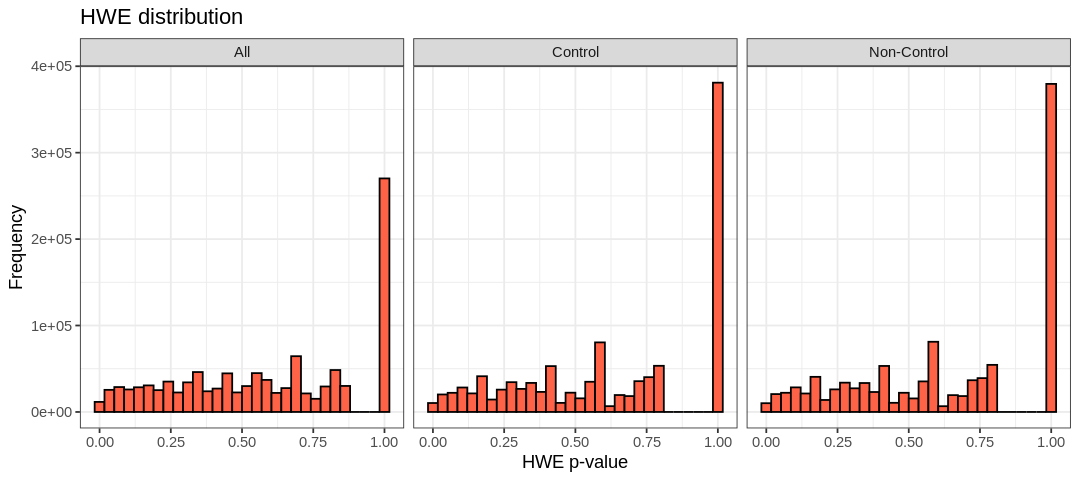

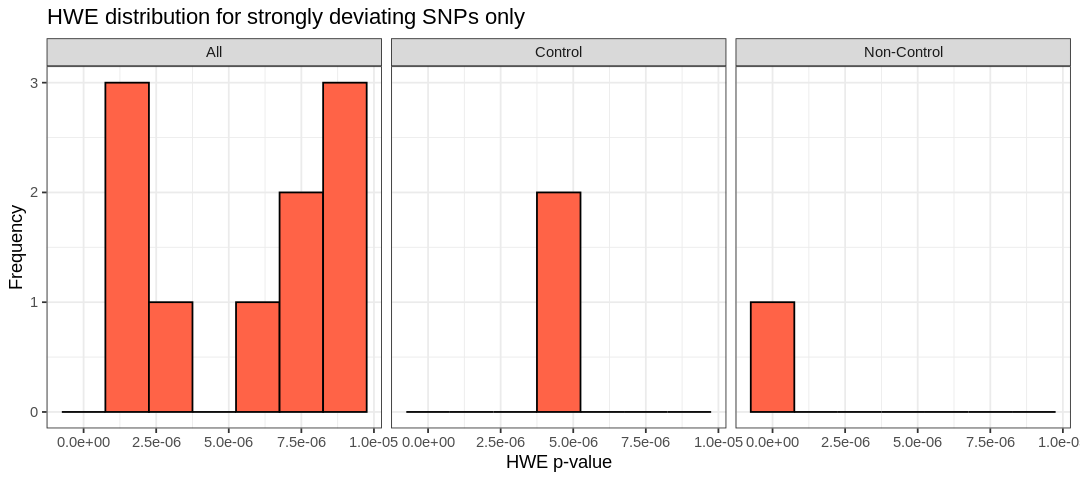

In [3]:
#| label: fig-HWE
#| fig-cap: "HWE p-values calculated with PLINK and zoom for the SNPs deviating from HWE. We can spot some deviations from HWE in the zoomed plot. Note that the p+values for the phenotype `All` is not the merging of the barplots from the other two phenotypes!"
suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

# maf_freq histogram
hist.hwe <- ggplot(hwe, aes(x=hwe[,9])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "HWE distribution") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  facet_wrap(~Phenotype) +
  theme_bw()

# maf_freq histogram
hist.hwe_below_threshold <- ggplot(hwe_zoom, aes(x=hwe_zoom[,9])) +
  geom_histogram(binwidth = 0.0000015, col = "black", fill="tomato") + 
  labs(title = "HWE distribution for strongly deviating SNPs only") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  facet_wrap(~Phenotype) +
  theme_bw()

show(hist.hwe)
show(hist.hwe_below_threshold)

# Save plots 
suppressMessages({
ggsave(plot=hist.hwe, filename="Results/GWAS3/histhwe.png");
ggsave(plot=hist.hwe_below_threshold, filename="Results/GWAS3/histhwe_below_threshold.png");})

<img src="Images/bash.png" alt="bash" width="40">  Almost all of our SNPs are in HWE, as determined by testing whether the alleles follow a binomial distribution. However, in our zoomed-in plot, we can spot a few extreme deviations. We can remove these outliers using the option `--hwe` in PLINK with the specified threshold. Note that `--hwe` filters only on controls, so if you want to apply the threshold to non-controls as well, include the `include-nonctrl` in the command. In the two steps below, we filter only controls with threshold `1e-6` and then all phenotypes with threshold `1e-10`:

In [1]:
plink --bfile Results/GWAS3/HapMap_3_r3_5 --hwe 1e-6 --make-bed --out Results/GWAS3/HapMap_3_r3_5_onlycontrols --silent

In [2]:
plink --bfile Results/GWAS3/HapMap_3_r3_5_onlycontrols --hwe 1e-10 include-nonctrl --make-bed --out Results/GWAS3/HapMap_3_r3_6 --silent

# Heterozygosity Rate

A somewhat similar idea to HWE, but applied to individuals instead of SNPs (if an individual had a ton of A/B calls but no A/A or B/B calls, or vice versa, that would indicate something was wrong):

## Command

PLINK has no summary statistic for heterozygosity of individuals. Instead, we will first prune the dataset, checking heterozygosity on a **set of SNPs which are not highly correlated**. We do this because highly correlated regions reduce the power of our analysis. To generate a list of non-(highly)correlated SNPs, we exclude (`--exclude`) high inversion regions (already saved in `Data/inversion.txt`) and prune the SNPs using the option `--indep-pairwise`. The parameters `50 5 0.2` stand respectively for: the window size, the number of SNPs to shift the window at each step, and the multiple correlation coefficient for a SNP being regressed on all other SNPs simultaneously.

In [5]:
plink --bfile Results/GWAS3/HapMap_3_r3_6 --exclude Data/inversion.txt --range --indep-pairwise 50 5 0.2 --out Results/GWAS3/indepSNP --silent

With this pruned list, we measure the heterozygosity rates of the individuals in the remaining independent SNPs.

In [6]:
plink --bfile Results/GWAS3/HapMap_3_r3_6 --extract Results/GWAS3/indepSNP.prune.in --het --out Results/GWAS3/R_check --silent

<img src="Images/R.png" alt="R" width="40"> Now, let's plot the distribution of heterozygosity rates. Again, we will first have a look at the heterozygosity table. When using the `--het` option in PLINK, the output table has the following columns:

- FID: Family ID of the individual.
- IID: Individual ID within the family.
- O(HOM): Observed number of homozygous genotypes.
- E(HOM): Expected number of homozygous genotypes under Hardy-Weinberg equilibrium.
- N(NM): Number of non-missing autosomal genotypes.
- F: Inbreeding coefficient (F), which is calculated as 
$$\tfrac{(E(HOM)−O(HOM))}{N(NM)}.

In [3]:
het <- read.table("Results/GWAS3/R_check.het", head=TRUE)
head(het)

,FID,IID,O.HOM.,E.HOM.,N.NM.,F
,<int>,<chr>,<int>,<dbl>,<int>,<dbl>
1,1328,NA06989,66999,67450,103892,-0.0125100
2,1377,NA11891,66840,66820,102941,0.0005092
3,1349,NA11843,67243,67550,104055,-0.0085140
4,1330,NA12341,66648,67390,103809,-0.0203700
5,1344,NA10850,67411,67510,103988,-0.0028170
6,1328,NA06984,66938,67230,103577,-0.0081300


We are going to calculate by hand the heterozygosity rates so we can plot them (not by default in the table). The formula for the rates is $N(NM)-O(HOM)/N(NM)$

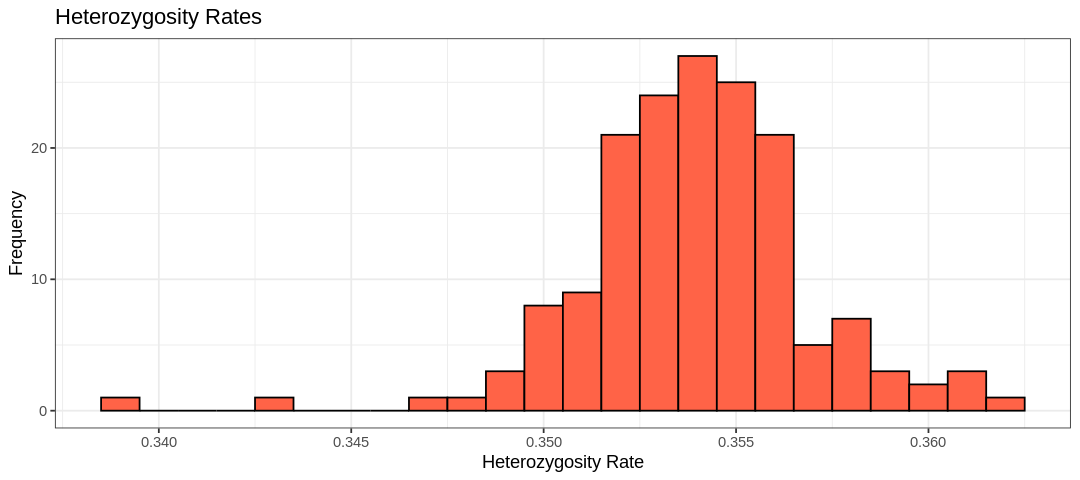

In [4]:
#| label: fig-HET
#| fig-cap: "Barplot of heterozigosity rates."

suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

# plink.imiss histogram
hist.het <- ggplot(het, aes(x=HET_RATE)) +
  geom_histogram(binwidth = 0.001, col = "black", fill="tomato") + 
  labs(title = "Heterozygosity Rates") + 
  xlab("Heterozygosity Rate") + 
  ylab("Frequency") + 
  theme_bw()


show(hist.het)

# Save plots 
suppressMessages(ggsave(plot=hist.het, filename="Results/GWAS3/heterozygosity.png"))

As a rule of thumb, we want to remove individuals who deviate more than 3 standard deviations (sd) from the heterozygosity rate mean. For data manipulation, we recommend using the `bash` command line. However, when performing statistical calculations, `R` is more convenient, hence the use of `R` for this step. 

Let's create a file subsetting the heterozygosity table based on 3 standard deviations away from the mean so that it can be used for removal by PLINK. We also add a column `HET_DST` to the table, containing the standardized values of heterozygosities.

In [5]:
library(dplyr)

het <- read.table("Results/GWAS3/R_check.het", head=TRUE)
het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

het_fail <- subset(het, (het$HET_RATE < mean(het$HET_RATE)-3*sd(het$HET_RATE)) | 
                    (het$HET_RATE > mean(het$HET_RATE)+3*sd(het$HET_RATE)))

het_fail$HET_DST <- (het_fail$HET_RATE-mean(het$HET_RATE))/sd(het$HET_RATE);

write.table(het_fail, "Results/GWAS3/fail-het-qc.txt", row.names=FALSE, quote=FALSE)

The output of this command is `fail-het-qc.txt`. 

:::{.callout-important title="Stop - Read - Solve"}

Let's check how many individuals are picked up as having a heterozygosity rate deviating more than 3 SD's from the mean. 

Hint: `wc -l` counts only the lines in the file (incl. header)

:::

In [ ]:
#Write your code here

:::{.callout-tip title="Solution" collapse="true"}

`wc -l Results/GWAS3/fail-het-qc.txt`

We can count 3 lines (one is the header), meaning there are two individuals to be filtered out. To use the file in PLINK, we need only the first two columns (Family ID and Individual ID) as shown below

:::

Here is how the file looks like. We need the first two columns to create the list of individuals to remove from the data.

In [2]:
cat Results/GWAS3/fail-het-qc.txt

FID IID O.HOM. E.HOM. N.NM. F HET_RATE HET_DST
1330 NA12342 68056 67220 103550 0.0229 0.34277160791888 -3.74231467217876
1459 NA12874 68786 67550 104050 0.03379 0.338913983661701 -5.03987173113217


We use `awk` to print out the first two columns in the file `het-fail-ind.txt` and use the option `--remove` to filter out the individuals with PLINK.

In [4]:
awk '{print$1, $2}' Results/GWAS3/fail-het-qc.txt > Results/GWAS3/het-fail-ind.txt

plink --bfile Results/GWAS3/HapMap_3_r3_6 --remove Results/GWAS3/het-fail-ind.txt --make-bed --out Results/GWAS3/HapMap_3_r3_7 --silent

After all filtering is done, we are left with 161 individuals and a total of 1073788 SNPs

In [7]:
wc -l Results/GWAS3/HapMap_3_r3_7.bim

1073788 Results/GWAS3/HapMap_3_r3_7.bim


In [8]:
wc -l Results/GWAS3/HapMap_3_r3_7.fam

161 Results/GWAS3/HapMap_3_r3_7.fam


Look back at the very first run of PLINK. We had 1457897 SNPs and 165 individuals. We filtered out around 1/3 of all SNPs!

:::{.callout-important title="Challenge yourself: first quality control on mice data"}

We continue working with the mice data. Now we want to do a quality control workflow as we did before. Try to repeat all the steps, excluding the sex discrepancies, which cannot be done due to the missing sex chromosomes in the data:

1 - Missingness analysis and filtering, both per SNP and per individual. **Note**

2 - Minor Allele Frequency. **Note:** No need to extract chromosomes 1 to 22, since you already have only the first four.

3 - Hardy-Weinberg Equilibrium. **Note:** in this data there are is case-control, so you don't need to rename the columns `hwe$Phenotype` and `hwe_zoom$Phenotype`. Similarly, avoid using `include-nonctrl` in PLINK. This means also that in the R code you want to avoid the line with `facet_wrap` separating the group Phenotype for plotting.

4 - Heterozigosity rate. **Note:** here we do not have a list of regions with many inversions, so avoid using `--exclude Data/inversion.txt --range` in PLINK.

**General notes for the exercise:**

- Copy-paste all the commands you need from the tutorial, but remember to carefully check that the file names and options are correct to be used in your data.
- Use proper file names for the output of PLINK when filtering and creating new `bed/bim/fam` files. For example, when you apply the various filterings, create a new output name prefix instead of keeping use `mice`. Start from `mice`, then create `mice_miss`, `mice_miss_maf`, `mice_miss_maf_hwe`, `mice_miss_maf_hwe_het`, so that you can trace back all your work to each analysis step.
- Feel free to play with the code for creating plots and change colours, values, or making the plots better.
- Make use of Generative AI to get help for the code if you think it is not enough to use what provided in the tutorial, or if you want to explore something beyond the exercise.

:::

:::{.callout-tip title="Solution" collapse="true"}

1 - **Filtering excessive missing values.** first of all we begin by producing the sample-wise and variant-wise missing reports in format `.imiss` and `.lmiss`. Note that sex will not be considered at all by PLINK as mentioned in the warning.

In [1]:
plink --bfile Data/mice --missing --out Results/GWAS3/mice --silent

phenotypes to be ignored, use the --allow-no-sex flag.


Now we look at the histograms. The only thing needed to change in the code, compared to the tutorial, is the name of the two missingness reports.

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”


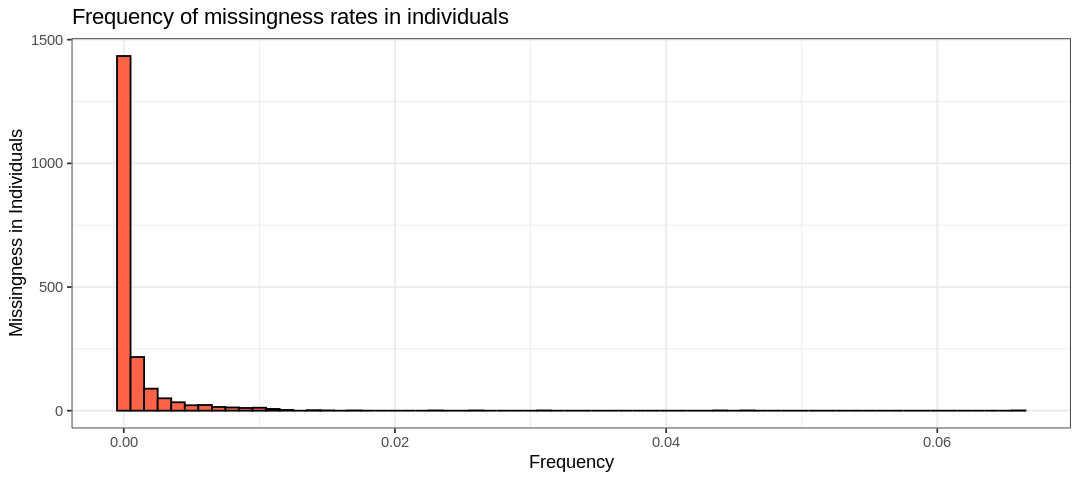

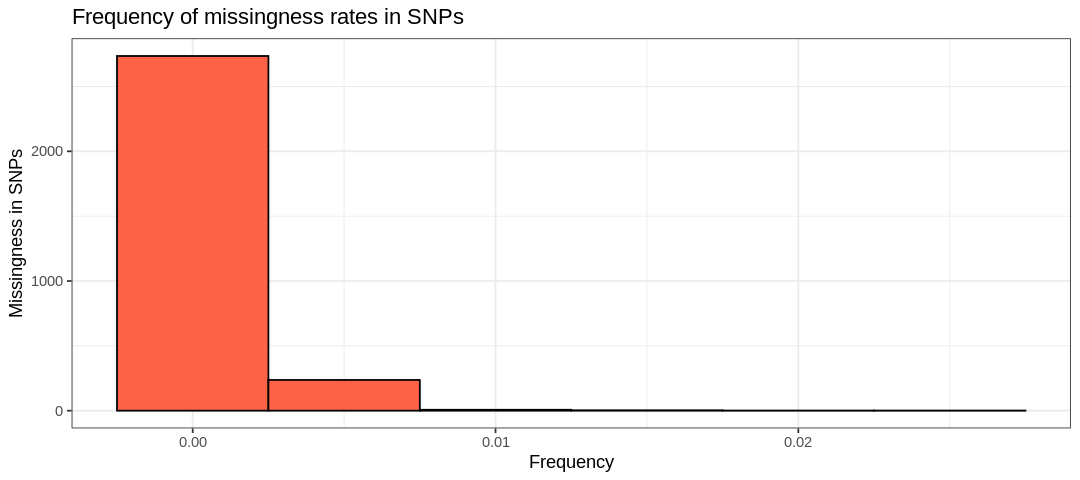

In [1]:
library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
indmiss <- read.table(file="Results/GWAS3/mice.imiss", header=TRUE)
snpmiss <- read.table(file="Results/GWAS3/mice.lmiss", header=TRUE)

#imiss histogram
hist.imiss <- ggplot(indmiss, aes(x=indmiss[,6])) +
  geom_histogram(binwidth = 0.001, col = "black", fill="tomato") + 
  labs(title = "Frequency of missingness rates in individuals") + 
  xlab("Frequency") + 
  ylab("Missingness in Individuals") + 
  theme_bw()

#lmiss histogram
hist.lmiss <- ggplot(snpmiss, aes(x=snpmiss[,5])) +
  geom_histogram(binwidth = 0.005, col = "black", fill="tomato") + 
  labs(title = "Frequency of missingness rates in SNPs") + 
  xlab("Frequency") + 
  ylab("Missingness in SNPs") + 
  theme_bw()

#show histograms
show(hist.imiss)
show(hist.lmiss)

The histograms do not show any high missingness for the variants (second plot), while there are a few individuals which we should filter out. Below, we filter only individuals with missingness above 2%, without choosing any variant filter. The new `bed,bim,fam` files have prefix `mice_miss`

In [3]:
plink --bfile Data/mice --mind .02 --make-bed --out Results/GWAS3/mice_miss --silent

phenotypes to be ignored, use the --allow-no-sex flag.


- 2. **Minimum Allele Frequency**. Let's calculate the MAF values using `--freq`: 

In [4]:
# Generate a plot of the MAF distribution.
plink --bfile Results/GWAS3/mice_miss --freq --out Results/GWAS3/mice_miss --silent

<img src="Images/R.png" alt="R" width="40"> Let's plot the MAF histogram using `R`. The second plot, is a zoom-in version with MAF up to 0.1 to observe the low MAF values. 

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2611 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


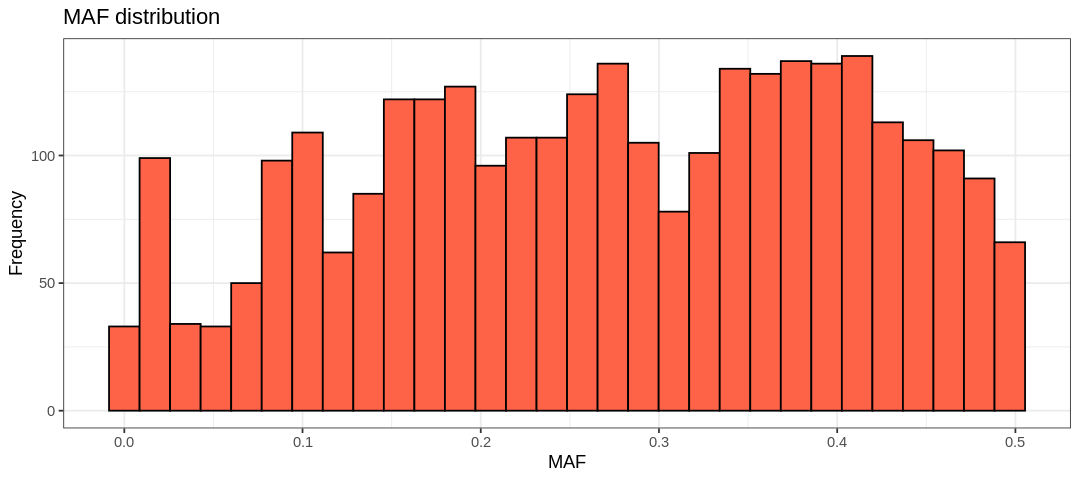

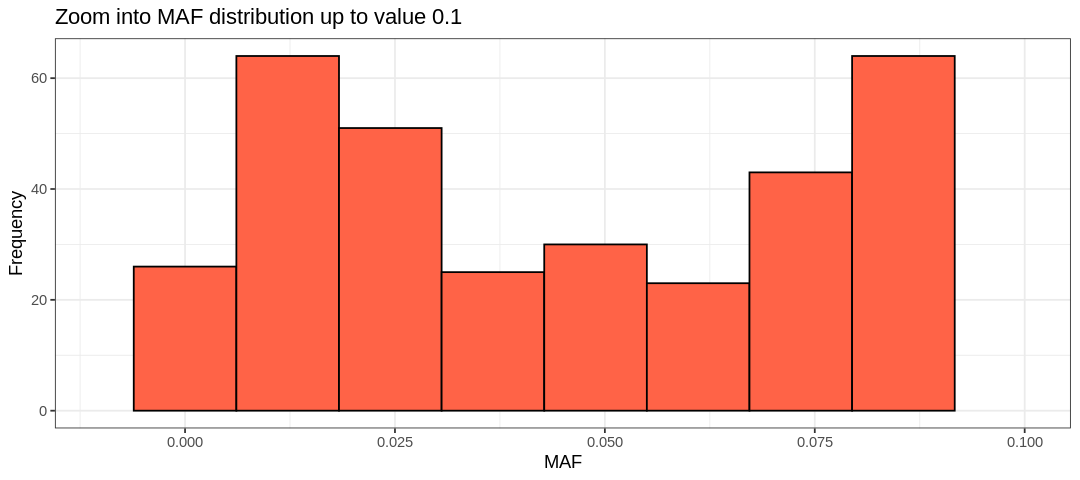

In [3]:
#| label: fig-MAF
#| fig-cap: "MAF plot for the autosomal SNPs only. Note the zoomed interval (0, 0.1)"

library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
maf_freq <- read.table("Results/GWAS3/mice_miss.frq", header =TRUE, as.is=T)

# maf_freq histogram
hist.maf <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "MAF distribution") + 
  xlab("MAF") + 
  ylab("Frequency") +
  theme_bw()

# zoom-in into X-axis
hist.maf.zoom <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato", bins = 10) + 
  labs(title = "Zoom into MAF distribution up to value 0.1") + 
  xlab("MAF") + 
  ylab("Frequency") +
  xlim(-.01, 0.1) +
  theme_bw()


show(hist.maf)
show(hist.maf.zoom)

There are two minor peaks in the histograms above, one at 0.05 and 0.1. Choosing 0.1 would remove over a hundred extra SNPs, while 0.05 should remove around less than 200. We can for example choose 0.05, but 0.1 is acceptable as well as it is another threshold often applied in literature.

In [1]:
# Remove SNPs with a low MAF frequency.
plink --bfile Results/GWAS3/mice_miss --maf 0.05 --make-bed --out Results/GWAS3/mice_miss_maf --silent

- 3. **Hardy Weinberg Equilibrium**. Here we need again to apply the option `hardy` to calculate observed and expected heterozigous frequencies and p-values for the binomial test. Note how column `TEST` considers all individuals ( `ALL(NP)` stands for `ALL Not Pruned`).

In [2]:
plink --bfile Results/GWAS3/mice_miss_maf --hardy --out Results/GWAS3/mice_miss_maf --silent

awk '{ if ($9 <0.00001) print $0 }' Results/GWAS3/mice_miss_maf.hwe > Results/GWAS3/mice_miss_maf.deviating.hwe

In [3]:
head Results/GWAS3/mice_miss_maf.hwe

 CHR                  SNP     TEST   A1   A2                 GENO   O(HET)   E(HET)            P 
   1            rs3683945  ALL(NP)    A    G         358/1002/572   0.5186   0.4939      0.03035
   1            rs3707673  ALL(NP)    G    A         359/1003/572   0.5186   0.4939      0.03048
   1            rs6269442  ALL(NP)    A    G          252/887/791   0.4596    0.461       0.8824
   1            rs6336442  ALL(NP)    A    G         358/1003/572   0.5189   0.4939      0.02714
   1           rs13475700  ALL(NP)    A    C          33/442/1458   0.2287   0.2283            1
   1            rs3658242  ALL(NP)    A    T         359/1003/572   0.5186   0.4939      0.03048
   1           rs13475701  ALL(NP)    C    G          33/481/1417   0.2491   0.2432       0.3045
   1            rs6198069  ALL(NP)    A    G          186/802/945   0.4149   0.4229       0.4197
   1            rs3659303  ALL(NP)    A    G         360/1001/571   0.5181    0.494      0.03419


There are 355 variants to remove with a p-value below 0.00001

In [5]:
wc -l Results/GWAS3/mice_miss_maf.deviating.hwe

356 Results/GWAS3/mice_miss_maf.deviating.hwe


Now we create histograms to look at the p-values from the tables above. We do not need to use the case-control renaming and plotting categories.

In [1]:
library(dplyr)

# Read data into R using dplyr library 
hwe <- read.table(file="Results/GWAS3/mice_miss_maf.hwe", header=TRUE)
hwe_zoom <- read.table(file="Results/GWAS3/mice_miss_maf.deviating.hwe", header=FALSE)
colnames(hwe_zoom) <- colnames(hwe)

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Here, we print the first rows of the two generated tables

In [2]:
#| label: fig-HWEtables
#| fig-cap: "HWE tables from PLINK"

head(hwe)
head(hwe_zoom)

,CHR,SNP,TEST,A1,A2,GENO,O.HET.,E.HET.,P
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1,rs3683945,ALL(NP),A,G,358/1002/572,0.5186,0.4939,0.03035
2,1,rs3707673,ALL(NP),G,A,359/1003/572,0.5186,0.4939,0.03048
3,1,rs6269442,ALL(NP),A,G,252/887/791,0.4596,0.4610,0.88240
4,1,rs6336442,ALL(NP),A,G,358/1003/572,0.5189,0.4939,0.02714
5,1,rs13475700,ALL(NP),A,C,33/442/1458,0.2287,0.2283,1.00000
6,1,rs3658242,ALL(NP),A,T,359/1003/572,0.5186,0.4939,0.03048


,CHR,SNP,TEST,A1,A2,GENO,O.HET.,E.HET.,P
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1,rs13475729,ALL(NP),G,A,46/339/1549,0.1753,0.1980,3.014e-06
2,1,rs13475730,ALL(NP),G,A,46/339/1547,0.1755,0.1982,3.079e-06
3,1,rs3654377,ALL(NP),G,A,46/339/1549,0.1753,0.1980,3.014e-06
4,1,rs3655978,ALL(NP),A,G,46/339/1545,0.1756,0.1984,3.146e-06
5,1,rs13475731,ALL(NP),A,G,46/339/1548,0.1754,0.1981,3.046e-06
6,1,rs3670630,ALL(NP),A,C,46/339/1545,0.1756,0.1984,3.146e-06


Now, we can plot the histograms. We isolate each "phenotype" to see if there are any significant differences in p-value distribution between them.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


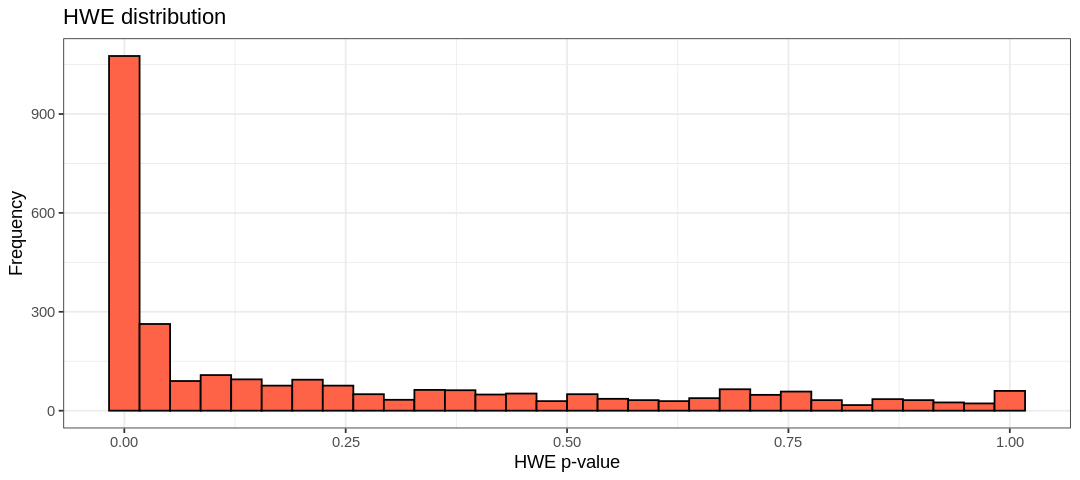

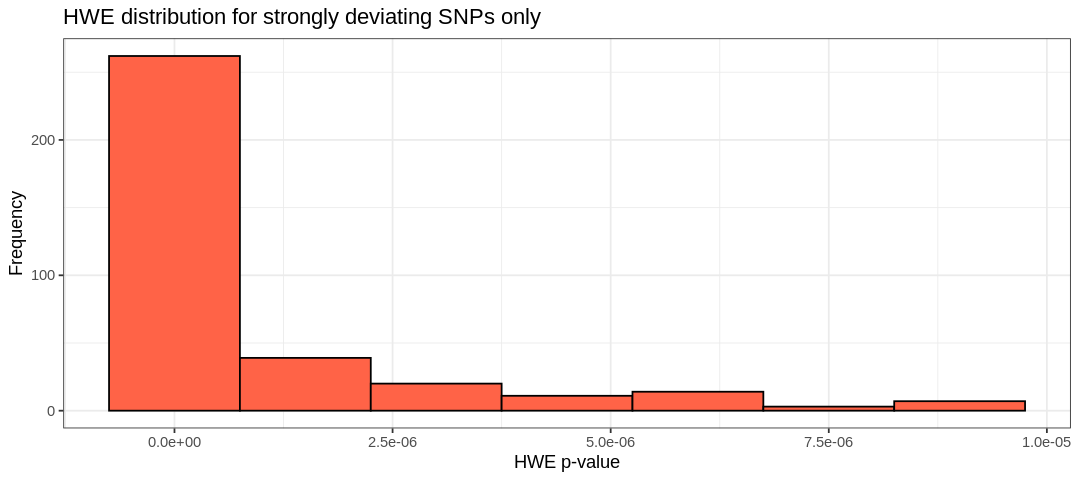

In [3]:
#| label: fig-HWE
#| fig-cap: "HWE p-values calculated with PLINK and zoom for the SNPs deviating from HWE. We can spot some deviations from HWE in the zoomed plot. Note that the p+values for the phenotype `All` is not the merging of the barplots from the other two phenotypes!"
suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

# maf_freq histogram
hist.hwe <- ggplot(hwe, aes(x=hwe[,9])) +
  geom_histogram(col = "black", fill="tomato") + 
  labs(title = "HWE distribution") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  theme_bw()

# maf_freq histogram
hist.hwe_below_threshold <- ggplot(hwe_zoom, aes(x=hwe_zoom[,9])) +
  geom_histogram(binwidth = 0.0000015, col = "black", fill="tomato") + 
  labs(title = "HWE distribution for strongly deviating SNPs only") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  theme_bw()

show(hist.hwe)
show(hist.hwe_below_threshold)

We choose the threshold 1e-5 and create the new filtered data

In [1]:
plink --bfile Results/GWAS3/mice_miss_maf --hwe 1e-5 --make-bed --out Results/GWAS3/mice_miss_maf_hwe --silent

4 - **Heterozigosity rate.** Now we look at genotype calls at each individual's level. First, we create a list of SNPs for which there is lower correlation, so to avoid linkage disequilibrium.

In [3]:
plink --bfile Results/GWAS3/mice_miss_maf_hwe --indep-pairwise 50 5 0.2 --out Results/GWAS3/mice_indepSNP --silent

With this pruned list, we measure the heterozygosity rates of the individuals in the remaining independent SNPs.

In [4]:
plink --bfile Results/GWAS3/mice_miss_maf_hwe --extract Results/GWAS3/mice_indepSNP.prune.in --het --out Results/GWAS3/mice_R_check --silent

How does the table with the SNPs look like?

In [5]:
head -5 Results/GWAS3/mice_R_check.het

         FID          IID       O(HOM)       E(HOM)        N(NM)            F
  A048005080   A048005080          112        109.5          184      0.03357
  A048006063   A048006063          111        109.5          184      0.02015
  A048006555   A048006555          105        109.5          184     -0.06039
  A048007096   A048007096           94        109.5          184       -0.208


We are going to calculate by hand the heterozygosity rates so we can plot them (not by default in the table). The formula for the rates is $N(NM)-O(HOM)/N(NM)$

Warning message:
“package ‘ggplot2’ was built under R version 4.3.3”


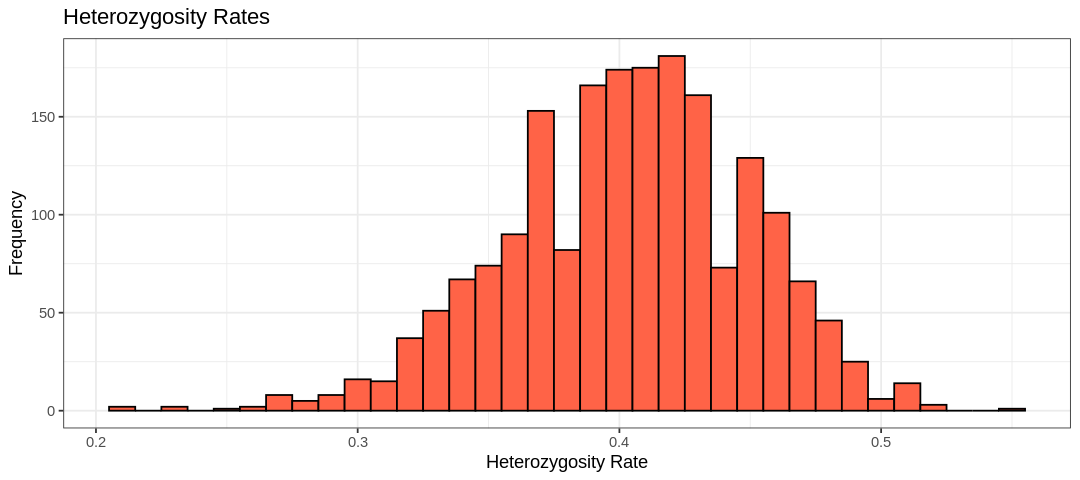

In [1]:
#| label: fig-HET
#| fig-cap: "Barplot of heterozigosity rates."

library(ggplot2)
options(repr.plot.width = 9, repr.plot.height = 4)

het <- read.table("Results/GWAS3/mice_R_check.het", head=TRUE)

het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

# plink.imiss histogram
hist.het <- ggplot(het, aes(x=HET_RATE)) +
  geom_histogram(binwidth = 0.01, col = "black", fill="tomato") + 
  labs(title = "Heterozygosity Rates") + 
  xlab("Heterozygosity Rate") + 
  ylab("Frequency") + 
  theme_bw()


show(hist.het)

We reapply the filter to individuals with heterozigosity rate 3 standard deviations away from the mean

In [2]:
library(dplyr)

het <- read.table("Results/GWAS3/mice_R_check.het", head=TRUE)
het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

het_fail <- subset(het, (het$HET_RATE < mean(het$HET_RATE)-3*sd(het$HET_RATE)) | 
                    (het$HET_RATE > mean(het$HET_RATE)+3*sd(het$HET_RATE)))

het_fail$HET_DST <- (het_fail$HET_RATE-mean(het$HET_RATE))/sd(het$HET_RATE);

write.table(het_fail, "Results/GWAS3/mice-fail-het-qc.txt", row.names=FALSE, quote=FALSE)

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




the resulting table contains a few outlying individuals:

In [1]:
wc -l Results/GWAS3/mice-fail-het-qc.txt

9 Results/GWAS3/mice-fail-het-qc.txt


We use `awk` to print out the first two columns in the file `het-fail-ind.txt` and use the option `--remove` to filter out the individuals with PLINK.

In [2]:
awk '{print$1, $2}' Results/GWAS3/mice-fail-het-qc.txt > Results/GWAS3/mice-het-fail-ind.txt

plink --bfile Results/GWAS3/mice_miss_maf_hwe --remove Results/GWAS3/mice-het-fail-ind.txt --make-bed --out Results/GWAS3/mice_QCA --silent

What are we left with? 1926 samples with 2439 variants

In [4]:
wc -l Results/GWAS3/mice_QCA.fam
wc -l Results/GWAS3/mice_QCA.bim

1926 Results/GWAS3/mice_QCA.fam
2439 Results/GWAS3/mice_QCA.bim


:::

---

:::{.callout-note title="Wrapping up"}

In this tutorial, we have tried several quality control approaches in PLINK and calculated various statistics, which we visualized using `R`. In the next notebook, you will find even more examples of how you verify the quality of your data.

A table with a small recap of the options used in filtering with PLINK

| Step | Command | Function | Thresholds and explanation |
|---|---|---|---|
| 1: Missingness of SNPs | `--geno`| Excludes SNPs that are missing in a large proportion of the subjects. In this step, SNPs with low genotype calls are removed| We recommend first filtering SNPs and individuals based on a relaxed  threshold (0.2; >20%), as this will filter out SNPs and individuals  with very high levels of missingness. Then a filter with a more  stringent threshold can be applied (0.02)|
| 2: Missingness of individuals | `--mind`| Excludes individuals who have high rates of genotype missingness. In this step, individuals with low genotype calls are removed | Note, SNP filtering should be performed before individual filtering |
| 3: Sex discrepancy | `--check-sex`| Checks for discrepancies between the sex of the individuals recorded in the  dataset and their sex based on X chromosome heterozygosity/homozygosity  rates | Can indicate sample mix‐ups. If many subjects have this discrepancy, the data should be checked carefully. Males should have an X chromosome  homozygosity estimate >0.8 and females should have a value <0.2 |
| 4: Minor allele frequency (MAF) | `--maf` | Includes only SNPs above the set MAF threshold| SNPs with a low MAF are rare, therefore power is lacking for detecting SNP‐phenotype associations. These SNPs are also more prone to genotyping errors.  The MAF threshold should depend on your sample size,  larger samples can use lower MAF thresholds. Respectively, for large (N = 100.000) vs. moderate samples (N = 10000),  0.01 and 0.05 are commonly used as MAF thresholds|
| 5: Hardy-Weinberg equilibrium (HWE) | `--hwe` | Excludes markers which deviate from Hardy–Weinberg equilibrium | Common indicator of genotyping error, may also indicate evolutionary selection.  For binary traits, we suggest excluding: HWE p-value <1e−10 in cases and <1e−6 in controls. A less strict case threshold avoids discarding disease‐associated SNPs under selection.  For quantitative traits, we recommend HWE p-value <1e‐6. |
| 6: Heterozygosity | `R` code + `--remove` option in PLINK | Excludes individuals with high or low heterozygosity rates | Deviations can indicate sample contamination and inbreeding.  We suggest removing individuals who deviate ±3 SD from the samples' heterozygosity rate mean |

:::

# Bibliography